# **Logistic regression**

Here, we are going to predict churn customers using logistic regression and then we are going to evaulate our model using different evaluation matrics.

### **Content**

1. Loading and cleaning data
2. Class Imbalance
3. Predicting using logistic regression
4. Model evaluation

# **1. Load and cleaning data**

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

Data importing and preprocessing

In [2]:
# load data from file to existing envrionment
def load_data(filepath,format= 'csv'):
    if format == 'csv' :
        return pd.read_csv(filepath)
    elif format == 'xlsx':
        return pd.read_excel(filepath)
        

In [3]:
df_raw = load_data('../Data/WA_Fn-UseC_-Telco-Customer-Churn.csv','csv')
df_raw.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Rename column names and map values for numeric calculation
def clean_data(df):
    df.rename(columns={'gender':'Gender'
                       ,'customerID':'CustomerID'
                       ,'Contract':'ContractType'
                       ,'InternetService':'InternetServiceType'
                       ,'tenure':'Tenure'
                      }
              ,inplace=True)


    df['Partner'] = df.Partner.map({'Yes':1,'No':0})
    df['Dependents'] = df.Dependents.map({'Yes':1,'No':0})

    df['PhoneService'] = df.PhoneService.map({'Yes':1,'No':0})
    df['MultipleLines'] = df.MultipleLines.map({'Yes':1,'No':0,'No phone service':0})

    df['InternetService'] = df.InternetServiceType.map({'DSL':1,'Fiber optic':1,'No':0})
    df['OnlineSecurity'] = df.OnlineSecurity.map({'Yes':1,'No':0,'No internet service':0})
    df['OnlineBackup'] = df.OnlineBackup.map({'Yes':1,'No':0,'No internet service':0})
    df['DeviceProtection'] = df.DeviceProtection.map({'Yes':1,'No':0,'No internet service':0})
    df['TechSupport'] = df.TechSupport.map({'Yes':1,'No':0,'No internet service':0})
    df['StreamingTV'] = df.StreamingTV.map({'Yes':1,'No':0,'No internet service':0})
    df['StreamingMovies'] = df.StreamingMovies.map({'Yes':1,'No':0,'No internet service':0})

    df['IsContracted'] = df.ContractType.map({'One year':1,'Two year':1,'Month-to-month':0})
    df['PaperlessBilling'] = df.PaperlessBilling.map({'Yes':1,'No':0})
    df['Churn'] = df.Churn.map({'Yes':1,'No':0})
    
    df.loc[df['TotalCharges']==' ','TotalCharges'] = np.nan
    df['TotalCharges'] = df['TotalCharges'].astype('float64')
    df.loc[df['TotalCharges']==np.nan, 'TotalCharges'] = df['MonthlyCharges'] * df['Tenure']
    
    return df

In [5]:
# clean, shuffle and reindexing traing data set -- shuffling may improve cross validation accuracy
clean_df = shuffle(clean_data(df_raw.copy())).reset_index()
clean_df.head()

,index,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetServiceType,...,StreamingTV,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,IsContracted
0,412,5233-AOZUF,Female,0,1,0,29,1,1,Fiber optic,...,0,0,Month-to-month,1,Electronic check,74.95,2149.05,0,1,0
1,6189,4718-WXBGI,Male,0,1,1,72,1,1,DSL,...,1,1,Two year,1,Credit card (automatic),91.95,6614.90,0,1,1
2,3598,6185-TASNN,Male,1,0,0,1,1,0,DSL,...,0,0,Month-to-month,0,Electronic check,46.30,46.30,0,1,0
3,278,8645-KWHJO,Male,0,0,0,14,0,0,DSL,...,1,1,Month-to-month,1,Electronic check,55.00,771.95,0,1,0
4,2505,1776-SPBWV,Female,0,1,1,34,1,0,No,...,0,0,One year,1,Bank transfer (automatic),20.10,682.10,0,0,1


In [6]:
# define variables

categorical_vars = ['Gender','InternetServiceType','PaymentMethod','ContractType']
binary_vars = ['SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup'
               ,'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','PaperlessBilling','InternetService'
               , 'IsContracted']
numeric_vars = ['Tenure','MonthlyCharges']
target_var = 'Churn'

In [7]:
# encode categorical data to numeric using One-hot encoding method

def one_hot_encoding_features_df(df,cat_feat):
    cat_df=pd.get_dummies(df[cat_feat])
    return cat_df

In [8]:
# merge categorical, numerical, and binary data
#This function takes your encoded categorical, binary, and numeric feature tables and glues them together 
#into one table you can use for training your machine learning model.
def merge_df(categorical,binary,numerical):
    return pd.concat([categorical,binary,numerical],axis = 1)

In [9]:
feature_df = merge_df(
                     one_hot_encoding_features_df(clean_df,categorical_vars),
                     clean_df[binary_vars],
                     clean_df[numeric_vars])
target_df= clean_df[target_var]
feature_df

,Gender_Female,Gender_Male,InternetServiceType_DSL,InternetServiceType_Fiber optic,InternetServiceType_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,ContractType_Month-to-month,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,InternetService,IsContracted,Tenure,MonthlyCharges
0,True,False,False,True,False,False,False,True,False,True,...,0,0,0,0,0,1,1,0,29,74.95
1,False,True,True,False,False,False,True,False,False,False,...,1,1,1,1,1,1,1,1,72,91.95
2,False,True,True,False,False,False,False,True,False,True,...,0,0,0,0,0,0,1,0,1,46.30
3,False,True,True,False,False,False,False,True,False,True,...,0,1,1,1,1,1,1,0,14,55.00
4,True,False,False,False,True,True,False,False,False,False,...,0,0,0,0,0,1,0,1,34,20.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,True,False,False,True,False,False,False,True,False,False,...,0,1,0,1,1,1,1,1,57,95.25
7039,False,True,False,True,False,True,False,False,False,False,...,1,0,0,0,0,1,1,1,68,85.50
7040,True,False,False,True,False,False,False,False,True,True,...,0,0,0,0,0,0,1,0,1,71.10
7041,True,False,False,False,True,True,False,False,False,False,...,0,0,0,0,0,1,0,1,56,19.55


In [10]:
def train_test_split_fn(feature,target , test_size = None , random_state = 0):
    return train_test_split(feature , target , test_size = test_size ,random_state= random_state)

In [11]:
X_train ,X_test ,y_train ,y_test =train_test_split_fn(feature_df , target_df , test_size=0.2)

We need to apply scaling our features using StandardScaler before fitting the model 

 Fit the Scaler on Training Data Only
To avoid data leakage, always fit on the training set and then transform both training and test sets.

In [12]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# **2. Class Imbalance**

In [13]:
clean_df.Churn.value_counts(normalize= True)



Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Distribution of churn subs')

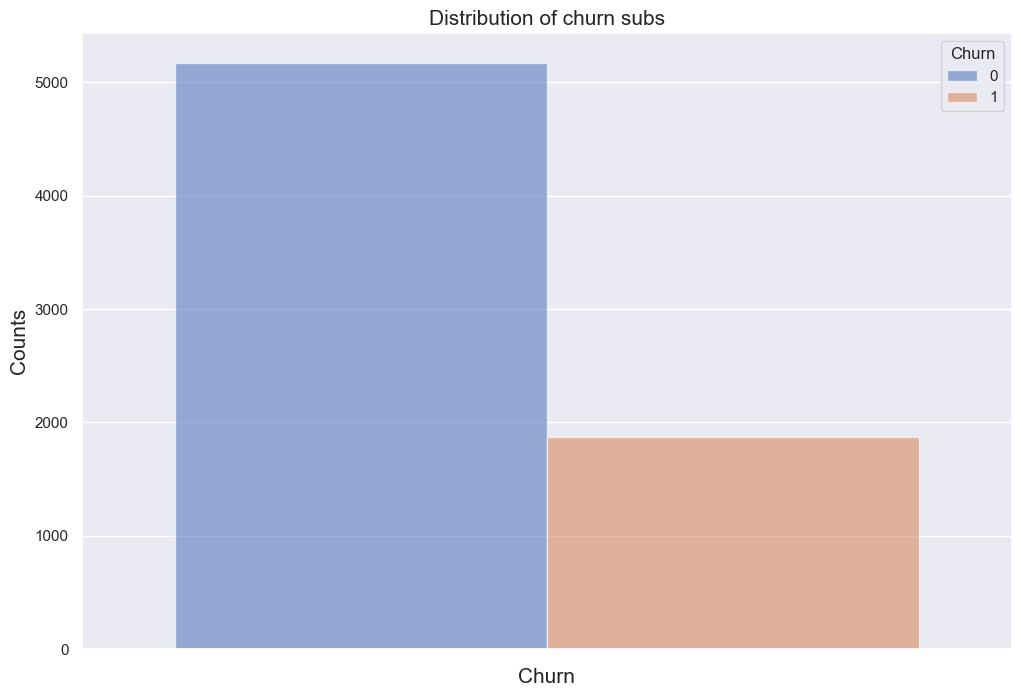

In [14]:
plt.figure(figsize=(12,8))
churn_cnt = clean_df.Churn.value_counts()
sns.barplot(hue=churn_cnt.index, y=churn_cnt.values, alpha=0.6,palette='muted')
plt.xlabel("Churn",fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.title("Distribution of churn subs",fontsize=15)

### **How to treat imbalanced datasets**

1. Oversampling - Balance it out by adding more under sample data
2. Undersampling - Balance it out by removing over sample data

### **Methods**

- Resample
    - Up sampling - You randomly resample minority class to create new data
    - Down sampling - You randomly resample majority class to remove some data
- SMOTE
    - You use nearest neighbors of the minority class to create new synthetic data

1. Upsampling the Minority Class (Manual Resampling):

In [15]:
X_train_us , y_train_us = resample(
    X_train[y_train == 1],                # Features of minority class
    y_train[y_train == 1],                # Labels of minority class
    replace=True,                         # With replacement (allows duplicates)
    n_samples=X_train[y_train == 0].shape[0],  # Match majority class count
    random_state=1                        # For reproducibility
)

# Combine upsampled minority with original majority
X_train_us = pd.concat([X_train_us,X_train[y_train == 0]])
y_train_us = pd.concat([y_train_us , y_train[y_train == 0]])

🧠 2. Upsampling Using SMOTE (Synthetic Minority Oversampling Technique)

In [16]:
sm = SMOTE(random_state= 12)
X_train_sm ,y_train_sm = sm.fit_resample(X_train , y_train)

📉 3. Downsampling the Majority Class (Manual Resampling)

In [17]:
X_train_ds , y_train_ds = resample(
    X_train[y_train == 0 ],
    y_train[y_train == 0],
    n_samples=X_train[y_train == 1].shape[0],
    random_state= 1 
)
X_train_ds = pd.concat([X_train_ds,X_train[y_train == 1]], axis = 0)
y_train_ds = pd.concat([y_train_ds,y_train[y_train == 1]], axis = 0)


print("original shape:", X_train.shape)
print("Upsampling using resample:", X_train_us.shape)
print("Upsampling using SMOTE:", X_train_sm.shape)
print("Downsampling using resample:", X_train_ds.shape)



original shape: (5634, 28)
Upsampling using resample: (8290, 28)
Upsampling using SMOTE: (8290, 28)
Downsampling using resample: (2978, 28)


3. Predicting using Logistic regression

To determine which upsampling/downsampling method works best for our churn prediction model
we should Compare All Methods Side-by-Side

For **each** method:

1. Train a `LogisticRegression()` model
2. Predict on the same `X_test`
3. Collect evaluation metrics:
    - Accuracy
    - Precision
    - Recall
    - F1-score
    - ROC AUC

Then we can:

- Compare results in a **table**
- Pick the one with best **F1-score** or **ROC AUC**                                                            

Now we need to apply Same Scaler to Resampled Sets

In [18]:
X_train_ds_scaled = scaler.transform(X_train_ds)
X_train_sm_scaled = scaler.transform(X_train_sm)
X_train_us_scaled = scaler.transform(X_train_us)

In [19]:

from sklearn.metrics import (
     accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score,roc_curve,confusion_matrix,classification_report
)


def evaluate_model(X_train, y_train, X_test, y_test, method_name):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    return {
        "Method": method_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    }

In [20]:
results = []

results.append(evaluate_model(X_train_us_scaled, y_train_us, X_test_scaled, y_test, "Upsampling"))
results.append(evaluate_model(X_train_ds_scaled, y_train_ds, X_test_scaled, y_test, "Downsampling"))
results.append(evaluate_model(X_train_sm_scaled, y_train_sm, X_test_scaled, y_test, "SMOTE"))

# Class weight = balanced
model_cw = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_cw.fit(X_train_scaled, y_train)
y_pred_cw = model_cw.predict(X_test_scaled)
y_proba_cw = model_cw.predict_proba(X_test_scaled)[:, 1]
results.append({
    "Method": "Class Weight",
    "Accuracy": accuracy_score(y_test, y_pred_cw),
    "Precision": precision_score(y_test, y_pred_cw),
    "Recall": recall_score(y_test, y_pred_cw),
    "F1 Score": f1_score(y_test, y_pred_cw),
    "ROC AUC": roc_auc_score(y_test, y_proba_cw)
})

metrics_df = pd.DataFrame(results)
metrics_df = metrics_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
print(metrics_df)


         Method  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Class Weight  0.747339   0.520134  0.815789  0.635246  0.847847
1    Upsampling  0.745209   0.517588  0.813158  0.632549  0.846780
2  Downsampling  0.727466   0.496805  0.818421  0.618290  0.842427
3         SMOTE  0.784954   0.594132  0.639474  0.615970  0.838057


### What the Metrics Say

- **SMOTE has the highest accuracy and precision**, but slightly lower recall than resampling.
- **Upsampling** and **Class Weight** have **very high recall** (>84%), meaning they capture more of the churners, 
- **F1 Score** is fairly close across all methods, slightly better in **Upsampling**.

Our goal is to reduce churn  so we are going to use Upsampling with high recall 

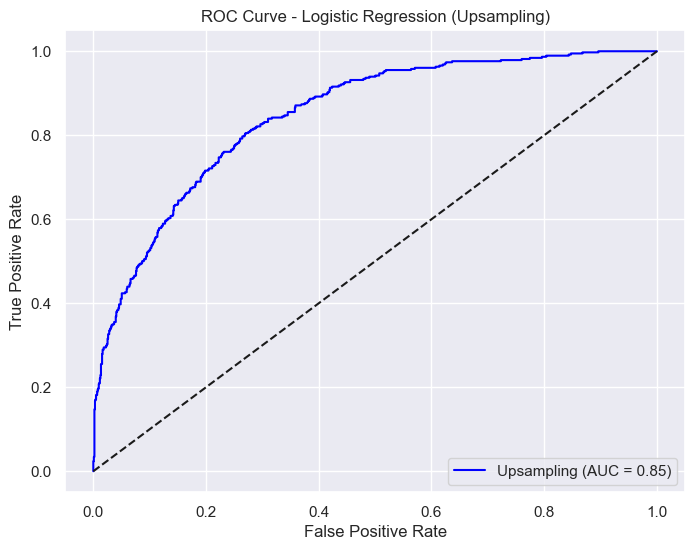

In [21]:


# Refit model on upsampling data if not already available
model_us = LogisticRegression(max_iter=1000, random_state=42)
model_us.fit(X_train_us_scaled, y_train_us)

# Predict probabilities
y_proba_us = model_us.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr_us, tpr_us, _ = roc_curve(y_test, y_proba_us)
roc_auc_us = roc_auc_score(y_test, y_proba_us)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_us, tpr_us, label=f"Upsampling (AUC = {roc_auc_us:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Upsampling)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Use Upsampled Data with Random Forest

###  Train Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier 

rf_model = RandomForestClassifier(random_state= 42 )
rf_model.fit(X_train_us_scaled,y_train_us)



RandomForestClassifier(random_state=42)

### Evaluate on Original (Unbalanced) Test Set

In [23]:
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:,1]

rf_results = {
    "Method": "Random Forest (Upsampled)",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1 Score": f1_score(y_test, y_pred_rf),
    "ROC AUC": roc_auc_score(y_test, y_proba_rf)
}

## Train & Evaluate Gradient Boosting

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_us_scaled, y_train_us)

y_pred_gb = gb_model.predict(X_test_scaled)
y_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

gb_results = {
    "Method": "Gradient Boosting (Upsampled)",
    "Accuracy": accuracy_score(y_test, y_pred_gb),
    "Precision": precision_score(y_test, y_pred_gb),
    "Recall": recall_score(y_test, y_pred_gb),
    "F1 Score": f1_score(y_test, y_pred_gb),
    "ROC AUC": roc_auc_score(y_test, y_proba_gb)
}


In [25]:
results.append(rf_results)
results.append(gb_results)

metrics_df = pd.DataFrame(results)
metrics_df = metrics_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
print(metrics_df)

                          Method  Accuracy  Precision    Recall  F1 Score  \
0                   Class Weight  0.747339   0.520134  0.815789  0.635246   
1  Gradient Boosting (Upsampled)  0.745209   0.517827  0.802632  0.629515   
2                     Upsampling  0.745209   0.517588  0.813158  0.632549   
3                   Downsampling  0.727466   0.496805  0.818421  0.618290   
4                          SMOTE  0.784954   0.594132  0.639474  0.615970   
5      Random Forest (Upsampled)  0.773598   0.585915  0.547368  0.565986   

    ROC AUC  
0  0.847847  
1  0.847787  
2  0.846780  
3  0.842427  
4  0.838057  
5  0.811388  


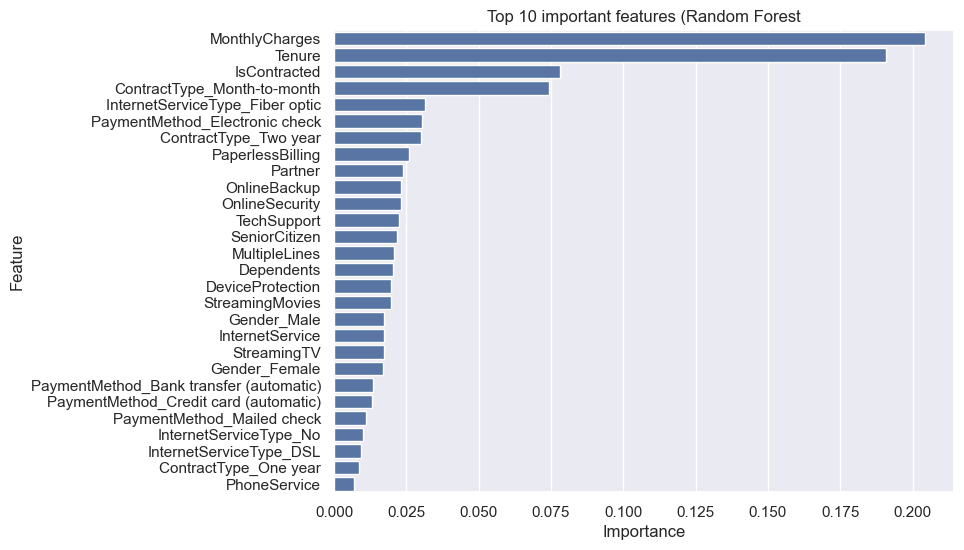

In [31]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

#create dataframe of importance 

feat_imp = pd.DataFrame({
    'Feature' :feature_names,
    'Importance': importances
}).sort_values(by= 'Importance' , ascending = False )

#plot

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature' , data= feat_imp)
plt.title(' important features (Random Forest')
plt.show()

We can do the same for GradientBoostingClassifierb

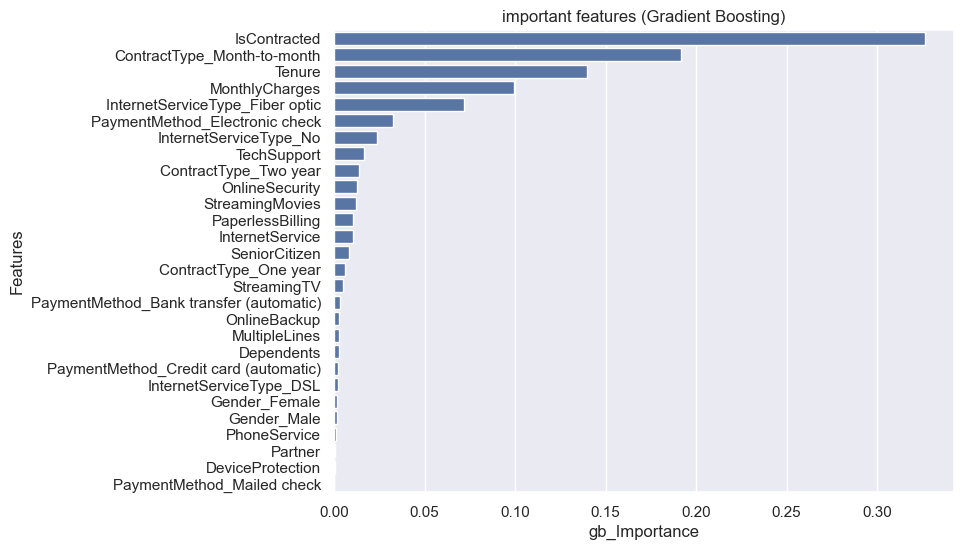

In [33]:
importance_gb = gb_model.feature_importances_
gb_feat_imp = pd.DataFrame({
    'Features': feature_names,
    'gb_Importance': importance_gb
    }).sort_values(by='gb_Importance' , ascending = False)

#plot 
plt.figure(figsize=(8,6))
sns.barplot(x='gb_Importance' , y='Features' , data=gb_feat_imp)
plt.title('important features (Gradient Boosting)')
plt.show()